In [1]:
import sys

In [2]:
%load_ext autoreload
%autoreload 2

import torch
from dig.ggraph.method.JTVAE.jtvae import JTVAE
from dig.ggraph.method.JTVAE import fast_jtnn
from dig.ggraph.method.JTVAE.fast_jtnn.datautils import MolTreeFolder, PairTreeFolder, MolTreeDataset

path_adj = "./"

<frozen importlib._bootstrap>:219: RuntimeWarning: to-Python converter for boost::shared_ptr<RDKit::FilterCatalogEntry const> already registered; second conversion method ignored.


In [3]:
from rdkit import Chem
from rdkit import RDLogger
RDLogger.DisableLog('rdApp.*')

In [4]:
from dig.ggraph.dataset import ZINC250k, ZINC800
from dig.ggraph.evaluation import RandGenEvaluator

In [5]:
dataset = ZINC800(one_shot=False, root=path_adj+'./datasets')

In [6]:
zinc_800_jt = torch.load(path_adj+"datasets/zinc_800_jt/processed/data.pt")

In [7]:
smiles = zinc_800_jt[-1]

In [8]:
import rdkit

In [9]:
rdkit.__version__

'2020.09.5'

In [10]:
JTVAE(smiles)

In [5]:
cset = set()
for smile in smiles:
    mol = fast_jtnn.MolTree(smile)
    for c in mol.nodes:         
        cset.add(c.smiles)

NameError: name 'smiles' is not defined

In [16]:
cset = set()
for smile in smiles:
    try:
        mol = fast_jtnn.MolTree(smile)
    except:
        print(smile)
        mol = fast_jtnn.MolTree(smile)
    for c in mol.nodes:         
        cset.add(c.smiles)

OCc1cn2c(n1)OC(Cl)=CC2


KekulizeException: Can't kekulize mol.  Unkekulized atoms: 5

In [7]:
smile="OCc1cn2c(n1)OC(Cl)=CC2"

OCc1cn2c(n1)OC(Cl)=CC2


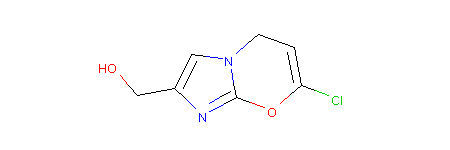

In [8]:
from dig.ggraph.method.JTVAE.fast_jtnn.chemutils import *
mol = get_mol(smile)
print(smile)
mol

In [9]:
Chem.MolFragmentToSmiles(mol, [7, 8, 10, 11, 4, 5], kekuleSmiles=False)

'C1=COcnC1'

In [10]:
Chem.MolFragmentToSmiles(mol, [7, 8, 10, 11, 4, 5], kekuleSmiles=True)

'C1=COCNC1'

In [18]:

cliques, edges = tree_decomp(mol)
nodes = []
root = 0
for i, c in enumerate(cliques):
    cmol = get_clique_mol(mol, c) 

KekulizeException: Can't kekulize mol.  Unkekulized atoms: 5

In [19]:
c

[7, 8, 10, 11, 4, 5]

KekulizeException: Can't kekulize mol.  Unkekulized atoms: 5

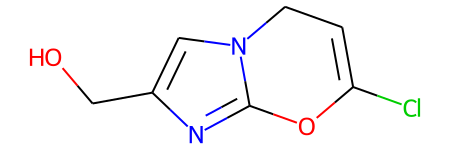

In [28]:
mol

In [8]:
# Define model
jtvae = JTVAE(smiles)
config = {"hidden_size": 420, "latent_size": 56, "depthT": 20, "depthG": 3}
jtvae.get_model('rand_gen', config)

KekulizeException: Can't kekulize mol.  Unkekulized atoms: 5

In [28]:
preprocessed = jtvae.preprocess(smiles)

100%|██████████| 800/800 [04:36<00:00,  2.90it/s] 


In [45]:
loader = MolTreeFolder(preprocessed, jtvae.vocab, 32, num_workers=4)
load_epoch = 0
lr = 1e-3
anneal_rate = 0.9
clip_norm = 50.0
num_epochs = 1
total_step = 0  # TODO args.load_epoch
beta = 0.0  # TODO args.beta
max_beta = 1.0
save_iter = 5000
step_beta = 0.002
anneal_iter = 40000
print_iter = 50
kl_anneal_iter = 2000
jtvae.train_rand_gen(loader, load_epoch, lr, anneal_rate, clip_norm, num_epochs, beta, max_beta, step_beta, anneal_iter, kl_anneal_iter, print_iter, save_iter)

Model #Params: 4260K


In [46]:
samples = list(map(Chem.MolFromSmiles, jtvae.run_rand_gen(30)))

In [47]:
res_dict = {'mols': samples, 'train_smiles': smiles}
evaluator = RandGenEvaluator()
results = evaluator.eval(res_dict)
print(results)

Valid Ratio: 30/30 = 100.00%
Unique Ratio: 17/30 = 56.67%
Novel Ratio: 30/30 = 100.00%
{'valid_ratio': 100.0, 'unique_ratio': 56.666666666666664, 'novel_ratio': 100.0}
